In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

import yaml

In [94]:
## Convenience functions

def plotLR( imgL, imgR ):
    fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
    axs[0].imshow(imgL, cmap="gray")
    axs[1].imshow(imgR, cmap="gray")
    plt.show()

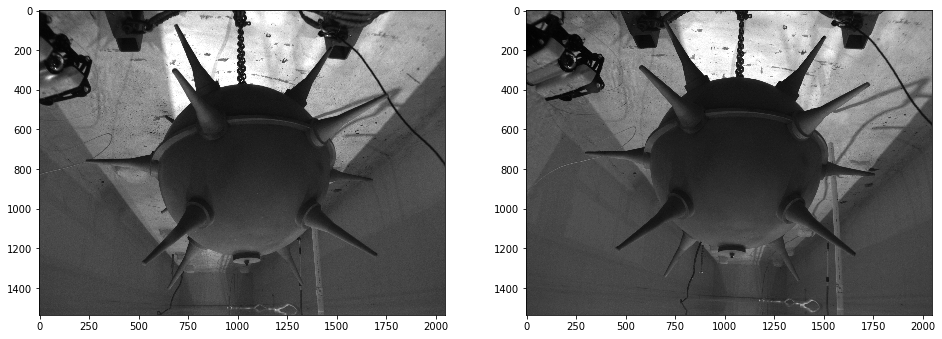

In [95]:
if False: 
    left_image_file = "images/left_raw.png"
    left_camera_file = "camera_info/left_rightside_up.yaml"
    #left_camera_file = "camera_info/18296567.yaml"

    right_image_file = "images/right_raw.png"
    right_camera_file = "camera_info/right_rightside_up.yaml"
    #right_camera_file = "camera_info/18457940.yaml"

    
left_image_file = "images/2019-05-02-12-30-41/left_00001.png"
left_camera_file = "camera_info/18482016_water.yaml"

right_image_file = "images/2019-05-02-12-30-41/right_00001.png"
right_camera_file = "camera_info/18505502_water.yaml"



imgL = cv2.imread(left_image_file)
imgR = cv2.imread(right_image_file)

imgLmono = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
imgRmono = imgR[:,:,1]


plotLR( imgLmono, imgRmono )


In [75]:
import pprint as pp

def mat_from_dict( d ):
    return np.reshape( d['data'], (d['rows'], d['cols'] ) )

def cam_from_yaml( y ):
    return { 'size': (y['image_width'], y['image_height']),
             'K': mat_from_dict( y['camera_matrix'] ),
             'dist': mat_from_dict( y['distortion_coefficients']),
             'projection': mat_from_dict( y['projection_matrix']),
             'rectification': mat_from_dict( y['rectification_matrix'])}

with open(left_camera_file) as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    leftCam = cam_from_yaml( y )
    
with open(right_camera_file) as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    rightCam = cam_from_yaml(y)
    
pp.pprint(leftCam)
print()
pp.pprint(rightCam)  
    

{'K': array([[1.65649224e+03, 0.00000000e+00, 1.05913976e+03],
       [0.00000000e+00, 1.65743079e+03, 7.97031797e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.198112,  0.073668, -0.001717,  0.002142,  0.      ]]),
 'projection': array([[1.83308684e+03, 0.00000000e+00, 1.08813101e+03, 0.00000000e+00],
       [0.00000000e+00, 1.83308684e+03, 7.73290573e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 'rectification': array([[ 9.97557e-01, -4.39600e-03,  6.97230e-02],
       [ 4.37300e-03,  9.99990e-01,  4.89000e-04],
       [-6.97240e-02, -1.83000e-04,  9.97566e-01]]),
 'size': (2048, 1536)}

{'K': array([[1.65710985e+03, 0.00000000e+00, 1.04225851e+03],
       [0.00000000e+00, 1.65830204e+03, 7.59957386e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.200918,  0.076485, -0.002856,  0.00314 ,  0.      ]]),
 'projection': array([[ 1.83308684e+03,  0.00000000e+00,  1

## Just Undistort

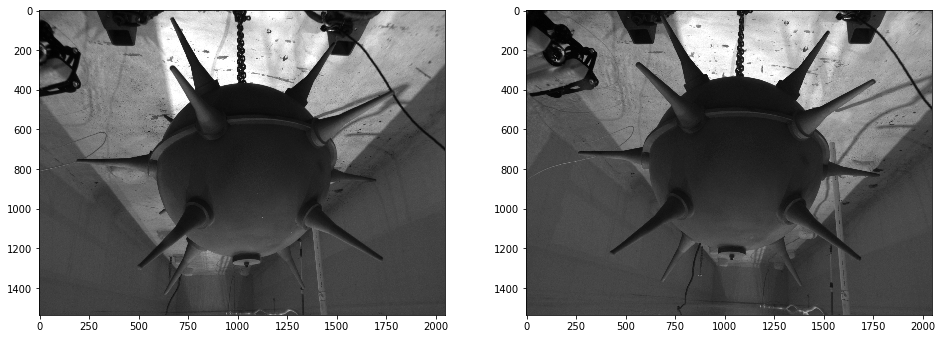

In [76]:
imgLundistort = cv2.undistort( imgLmono,  leftCam['K'],  leftCam['dist'])
imgRundistort = cv2.undistort( imgRmono, rightCam['K'], rightCam['dist'])

fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(imgLundistort, cmap="gray")
axs[1].imshow(imgRundistort, cmap="gray")
plt.show()

## Rectify

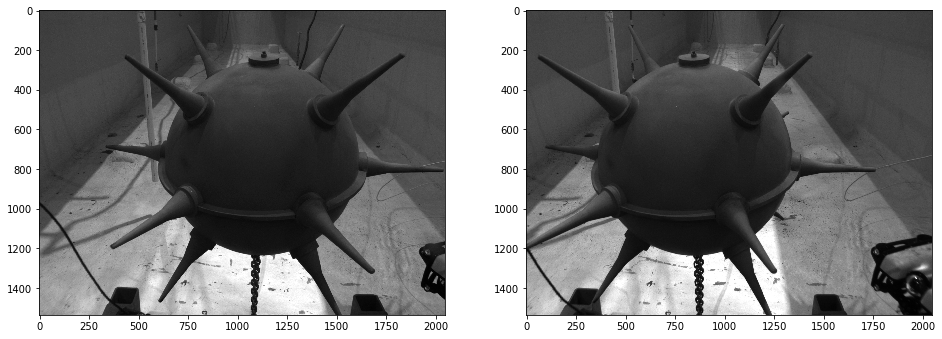

In [240]:
def remap( img, cam ):
    ## Extract newK from projection
    newK = cam['projection'][:,0:2]
    
    map1,map2 = cv2.initUndistortRectifyMap( cam['K'], cam['dist'], cam['rectification'], cam['projection'], cam['size'], cv2.CV_32FC1)
    return cv2.remap(img, map1, map2, cv2.INTER_LINEAR);

imgLrect = remap( imgLmono, leftCam )
imgRrect = remap( imgRmono, rightCam )

## Flip and swap
foo = cv2.rotate( imgRrect, cv2.ROTATE_180 )
imgRrect = cv2.rotate( imgLrect, cv2.ROTATE_180 )
imgLrect = foo


fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(imgLrect, cmap="gray")
axs[1].imshow(imgRrect, cmap="gray")
plt.show()

## Preprocessing before downsample

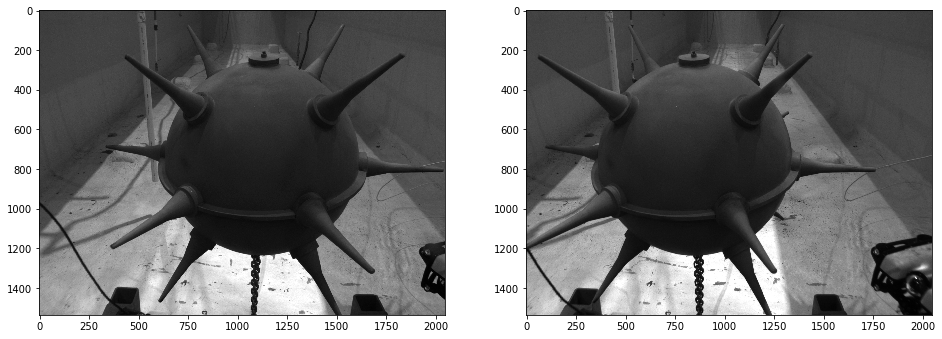

In [241]:
# imgLrect = cv2.equalizeHist( imgLrect )
# imgRrect = cv2.equalizeHist( imgRrect )

# clahe = cv2.createCLAHE()
# imgLrect = clahe.apply( imgLrect )
# imgRrect = clahe.apply( imgRrect )

plotLR( imgLrect, imgRrect )

## Downsample

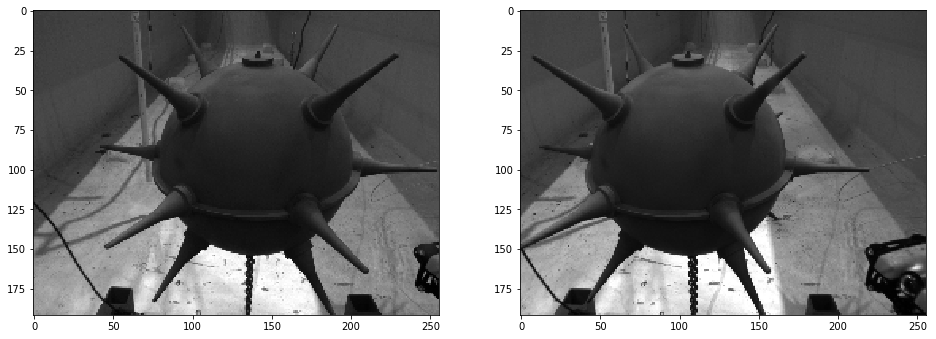

In [255]:
scale = 0.125
newSize = (int(imgLrect.shape[1]*scale), int(imgLrect.shape[0]*scale) )
#newSize = (256, int(imgLrect.shape[0]*scale) )



imgLresized = cv2.resize(imgLrect, newSize )
imgRresized = cv2.resize(imgRrect, newSize )



fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(imgLresized, cmap="gray")
axs[1].imshow(imgRresized, cmap="gray")
plt.show()

## Attempt pre-processing after rescale

## StereoBM algorithm

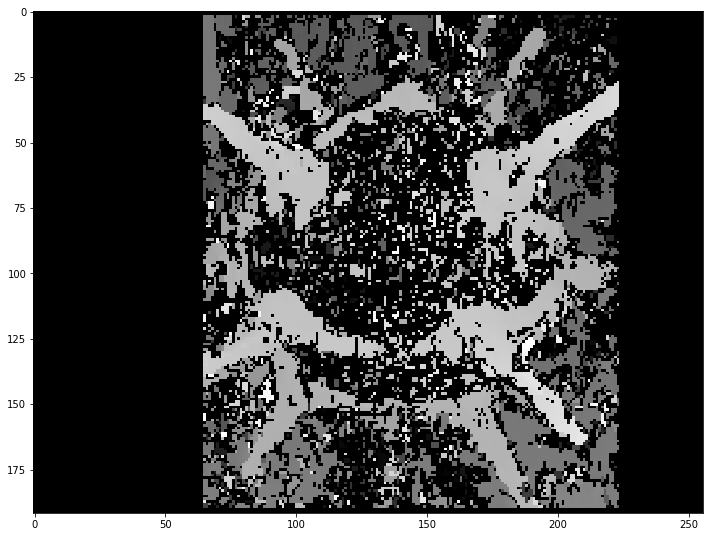

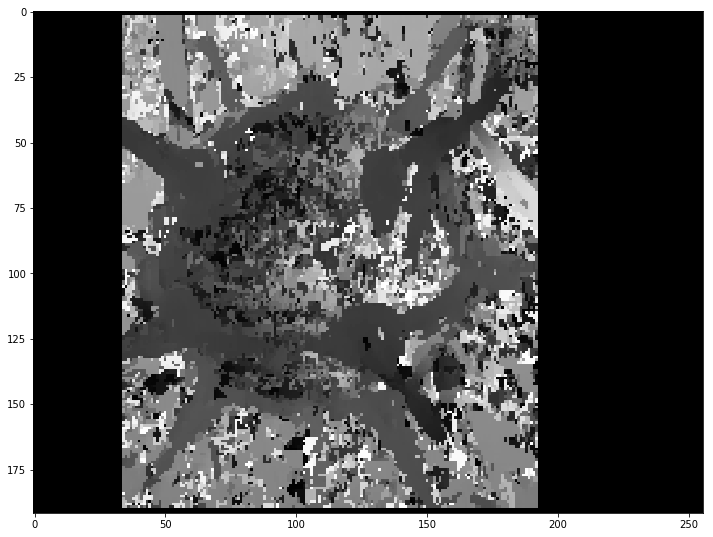

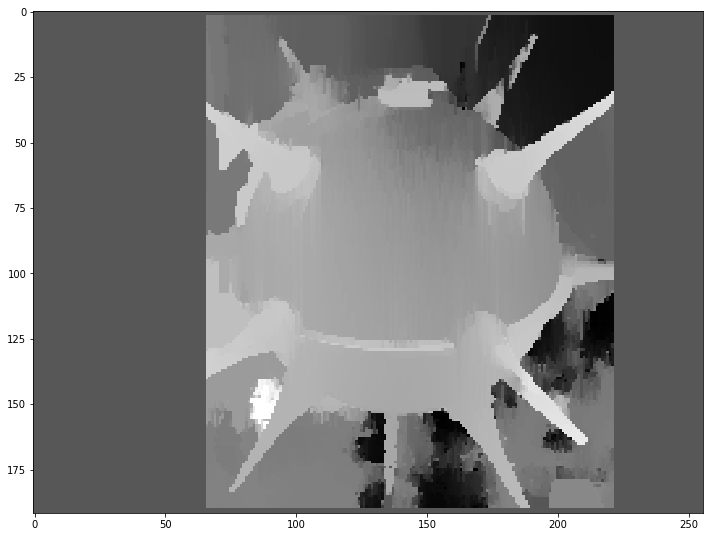

In [260]:
imgLstereo = imgLresized
imgRstereo = imgRresized

def do_stereo( stereo ):
    disparity = stereo.compute(imgLstereo,imgRstereo)

    plt.figure(figsize=(12,12))
    plt.imshow(disparity,'gray', )
    plt.show()

    
    right_matcher = cv2.ximgproc.createRightMatcher(stereo)
#     right_matcher = cv2.StereoBM_create(numDisparities=stereo.getNumDisparities(), blockSize=stereo.getBlockSize())

    ## These are set appropriately by createRightMatcher

    #right_matcher.setTextureThreshold(stereo.getTextureThreshold())
    right_matcher.setSpeckleWindowSize(stereo.getSpeckleWindowSize())
    right_matcher.setSpeckleRange(stereo.getSpeckleRange())
    dispR = right_matcher.compute(imgRstereo, imgLstereo)  
    
    ## Display right-to-left disparity
    plt.figure(figsize=(12,12))
    plt.imshow(dispR,'gray')
    plt.show()

    # FILTER Parameters
    lmbda = 10000
    sigma = 1.0
    #visual_multiplier = 1.0

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    wls_filter.setDepthDiscontinuityRadius(1)
    #wls_filter.setDepthDiscontinuityRadius(4)

    filteredImg = wls_filter.filter(disparity, imgLstereo, None, dispR, None, imgRstereo )

    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)

    plt.figure(figsize=(12,12))
    plt.imshow(filteredImg,'gray')
    plt.show()
    
    return disparity

   
min_disparity = -32
num_disparity = 96
block_size = 5
    
bm = cv2.StereoBM_create(numDisparities=num_disparity, blockSize=block_size)
bm.setMinDisparity(min_disparity)
#bm.setDisp12MaxDiff(2)
bm.setTextureThreshold(1)
# bm.setPreFilterSize( 27 );
# bm.setPreFilterCap( 63 );
#bm.setTextureThreshold( 20 );
#bm.setUniquenessRatio( 7 );
#bm.setSpeckleWindowSize( 0 );
#bm.setSpeckleRange( 2 );

do_stereo(bm);





## SGBN

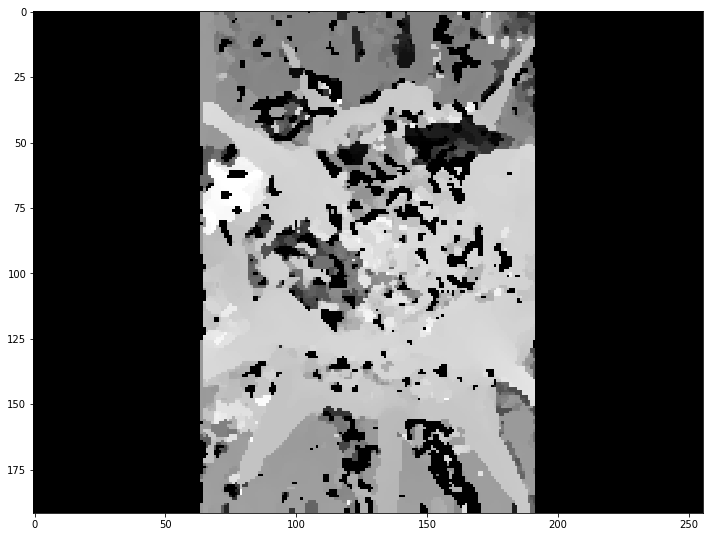

(192, 256)
(192, 256)


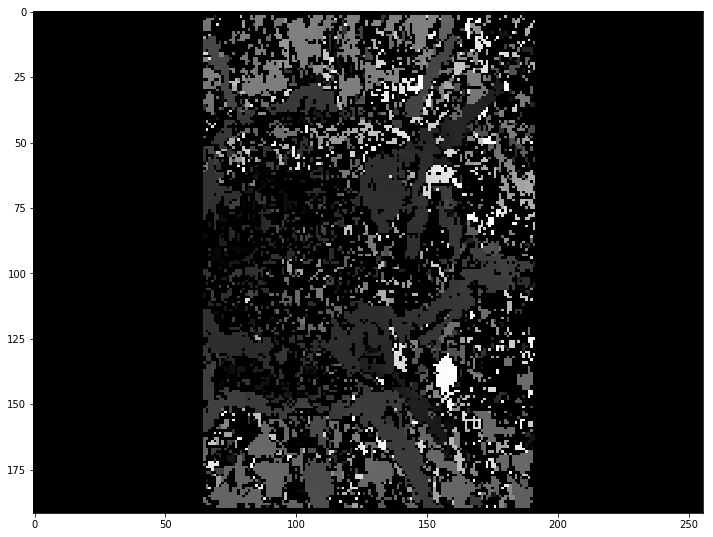

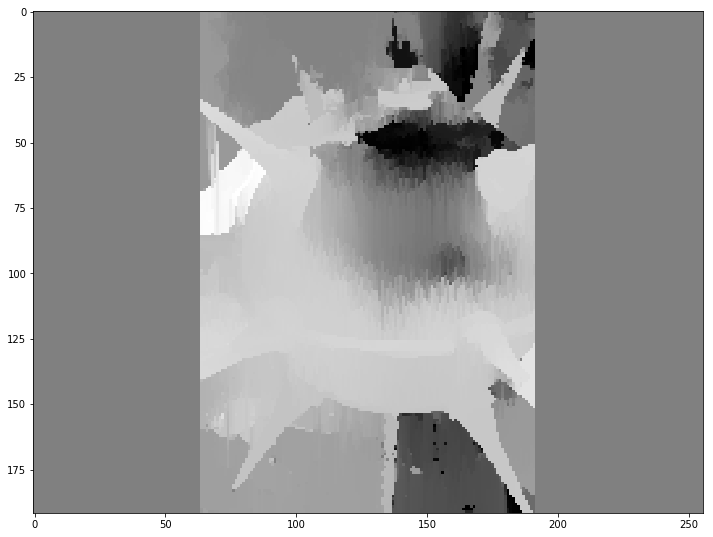

array([[-1040, -1040, -1040, ..., -1040, -1040, -1040],
       [-1040, -1040, -1040, ..., -1040, -1040, -1040],
       [-1040, -1040, -1040, ..., -1040, -1040, -1040],
       ...,
       [-1040, -1040, -1040, ..., -1040, -1040, -1040],
       [-1040, -1040, -1040, ..., -1040, -1040, -1040],
       [-1040, -1040, -1040, ..., -1040, -1040, -1040]], dtype=int16)

In [189]:


sgbm = cv2.StereoSGBM_create(minDisparity = min_disparity, 
                             numDisparities = max_disparity, 
                             blockSize=5) 
# ,
#                              disp12MaxDiff=10,
#                              P1 = 1,
#                              P2 = 4,
#                              uniquenessRatio=2,
#                              speckleWindowSize=50,
#                              speckleRange=2);

do_stereo(sgbm)

